In [551]:
import sys
import numpy as np
import csv
import numpy as np
import random
from scipy import stats
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from IPython.display import clear_output
from tqdm import tqdm

sys.path.insert(0, '../simulated_alignments/modules')
from classBCR import BCR
from gen_code_DNA import genetic_code
sys.path.insert(0, '../equilibrium_mutability/')
from equilibrium_mutability import site_specific_transitions, site_specific_rates
sys.path.append("../../../Downloads/DCATools")
from sequenceHandler import *
from dca import *

Null model for aa substitution spectra

In [14]:
#Dictionary of codon frequencies per amino acid:
codon_freqs = {}
# Read table of human codon frequencies (see reference in CSV file):
with open('../relative_mutability/human_codon_frequencies.csv','r') as codon_freq_file:
    for line in codon_freq_file:
        # Skip first 3 lines
        if line.find('#') == -1:
            aa = line.split(' ')[1]
            codon = line.split(' ')[0]
            frequency = line.split(' ')[2]

            if aa not in codon_freqs.keys():
                codon_freqs[aa] = {codon:frequency}
            else:
                codon_freqs[aa][codon] = frequency

    # Normalize so that freqs for each aa sum to 1 (some do not probably because of rounding error in the authors' report)
    for aa in codon_freqs.keys():
        freq_sum = 0
        for codon in codon_freqs[aa].keys():
            freq_sum = freq_sum + float(codon_freqs[aa][codon])

        for codon in codon_freqs[aa].keys():
            codon_freqs[aa][codon] = float(codon_freqs[aa][codon])/freq_sum
            

In [28]:
nucleotides  =['A','T','C','G']

In [51]:
sub_rate_dict = {'AG':4,'AT':1,'AC':1,'GA':4,'GT':1,'GC':1,'TA':1,'TC':4,'TG':1,'CA':1,'CG':1,'CT':4}

In [56]:
#create spectrum
spectra_mat = np.zeros((21,21))
for i in range(1,21):
    aa = invAaDict[i]
    for codon in codon_freqs[aa]:
        p_codon = codon_freqs[aa][codon]
        for k in range(len(codon)):
            for n in nucleotides:
                if codon[k] != n:
                    p_sub = sub_rate_dict[codon[k] + n]
                    temp = codon[:k] + n + codon[k+1:]
                    j = aaDict[genetic_code[temp]]
                    spectra_mat[i,j] = spectra_mat[i,j] + p_codon*p_sub

In [57]:
#normalize
for i in range(21):
    spectra_mat[i,i] = 0
for i in range(1,21):
    spectra_mat[i,:] = spectra_mat[i,:]/np.sum(spectra_mat[i,:])

In [61]:
for i in range(1,21):
    print(invAaDict[i]+':')
    for j in range(1,21):
        if spectra_mat[i,j] !=0:
            print(str(invAaDict[j]) + ":" + str(spectra_mat[i,j]))

A:
D:0.05528052805280528
E:0.028052805280528056
G:0.08333333333333333
P:0.08333333333333333
S:0.08333333333333333
T:0.3333333333333333
V:0.3333333333333333
C:
F:0.07142857142857142
G:0.07142857142857142
R:0.2857142857142857
S:0.14285714285714285
W:0.07142857142857142
Y:0.2857142857142857
D:
A:0.07142857142857142
E:0.14285714285714285
G:0.2857142857142857
H:0.07142857142857142
N:0.2857142857142857
V:0.07142857142857142
Y:0.07142857142857142
E:
A:0.07142857142857142
D:0.14285714285714285
G:0.2857142857142857
K:0.2857142857142857
Q:0.07142857142857142
V:0.07142857142857142
F:
C:0.07142857142857142
I:0.07142857142857142
L:0.42857142857142855
S:0.2857142857142857
V:0.07142857142857142
Y:0.07142857142857142
G:
A:0.08333333333333333
C:0.041666666666666664
D:0.16666666666666666
E:0.16666666666666666
R:0.25
S:0.16666666666666666
V:0.08333333333333333
W:0.020833333333333332
H:
D:0.07142857142857142
L:0.07142857142857142
N:0.07142857142857142
P:0.07142857142857142
Q:0.14285714285714285
R:0.285714

In [120]:
def translate(sequence):
        sequence = sequence.replace('.','')
        sequence = str.upper(sequence[0:int(len(str.upper(sequence))/3)*3])
        protein_seq = ''
        for site in range(0, len(sequence), 3):
            codon = genetic_code[sequence[site : site + 3]]
            protein_seq = protein_seq + codon
        return protein_seq, sequence

In [108]:
def is_valid_nt(seq):
    return not any(c not in 'gtcaGTCA.' for c in seq)

In [149]:
def is_pseudogene(seq):
    return any(c in '*' for c in seq)

In [392]:
def computeMutantPottsEnergiesDomains(h,J,sequence,mutations,nSplit):
    """ Computes the Potts energies for all mutants on the provided sequence

    Keyword Arguments:
        h (ndarray): 1-D array containing the potts model local biases h_i(A) in the following order: h_0(0),h_0(1),...,h_0(q),h_1(0),...,h_N(q)

        J (ndarray): 1-D array containing the potts model couplings J_ij(A,B) in the following order J_01(0,0),J_01(0,1),...,J_01(0,q),J_01(1,0),...,J_02(0,0),...,J_N-1,N(q,q)

        sequence (ndarray): A  numpy array containing the native sequence in numerical format
    
        mutations (list) : A list of mutations in string format in the following format S14T
    
        nSplit (int): The last position (zero-based) of the first domain/protein in the concatenated sequence, defining where the energy contributions are split.
    
    Returns:
        dEnergies (ndarray): An Mx3 array containing the delta Energy triplets (dE_intra1, dE_intra2, dE_inter) for each of the M mutants
    """
    mutations=np.asarray(mutations,dtype=str)
    energies = np.zeros((mutations.shape[0],3))
    N = len(sequence)
    q= 21
    Ns=nSplit+1

    
    for k,mutation in enumerate(mutations):
        iMut=int(mutation[1:-1])
        aaMut=aaDict[mutation[-1]]

        dH = h[q*iMut+aaMut]-h[q*iMut+sequence[iMut]]
        if iMut<Ns:
            dJ_intra1=(J[(iMut*N -int((iMut+2)*(iMut+1)/2)+np.arange((iMut+1),Ns))*q*q + q*aaMut+sequence[(iMut+1):Ns]]-
                       J[(iMut*N -int((iMut+2)*(iMut+1)/2)+np.arange((iMut+1),Ns))*q*q + q*sequence[iMut]+sequence[(iMut+1):Ns]]).sum()
            dJ_intra1+=(J[(np.arange(iMut)*N -((np.arange(iMut)+2)*(np.arange(iMut)+1)/2).astype(int)+iMut)*q*q + q*sequence[:iMut] +aaMut]-
                        J[(np.arange(iMut)*N -((np.arange(iMut)+2)*(np.arange(iMut)+1)/2).astype(int)+iMut)*q*q + q*sequence[:iMut]+sequence[iMut]]).sum()
           
            dJ_inter=(J[(iMut*N -int((iMut+2)*(iMut+1)/2)+np.arange(Ns,N))*q*q + q*aaMut+sequence[Ns:N]]-
                      J[(iMut*N -int((iMut+2)*(iMut+1)/2)+np.arange(Ns,N))*q*q + q*sequence[iMut]+sequence[Ns:N]]).sum()
            energies[k,:]=[dH+dJ_intra1,0.,dJ_inter]
            
        else:
            dJ_intra2=(J[(iMut*N -(iMut+2)*(iMut+1)/2+np.arange(iMut+1,N))*q*q + q*aaMut+sequence[(iMut+1):N]]-
                       J[(iMut*N -(iMut+2)*(iMut+1)/2+np.arange(iMut+1,N))*q*q + q*sequence[iMut]+sequence[(iMut+1):N]]).sum()
            dJ_intra2+=(J[(np.arange(Ns+1,iMut)*N -(np.arange(Ns+1,iMut)+2)*(np.arange(Ns+1,iMut)+1)/2+iMut)*q*q + q*sequence[Ns+1:iMut] +aaMut]-
                        J[(np.arange(Ns+1,iMut)*N -(np.arange(Ns+1,iMut)+2)*(np.arange(Ns+1,iMut)+1)/2+iMut)*q*q + q*sequence[Ns+1:iMut]+sequence[iMut]]).sum()
       
            dJ_inter=(J[(np.arange(Ns)*N -(np.arange(Ns)+2)*(np.arange(Ns)+1)/2+iMut)*q*q + q*sequence[:Ns] +aaMut]-
                        J[(np.arange(Ns)*N -(np.arange(Ns)+2)*(np.arange(Ns)+1)/2+iMut)*q*q + q*sequence[:Ns]+sequence[iMut]]).sum()
            energies[k,:]=[0.,dH+dJ_intra2,dJ_inter]
 
    return energies

def importhJ(filename,N,alph):
    hJ = np.fromfile('output_fullParams.dat', dtype=float)

    h_array = np.zeros(0)
    for i in range(0,N):
        h_array = np.concatenate((h_array,hJ[(alph+N*alph*alph)*i:(alph+N*alph*alph)*i+alph]))
    
    h_mat = np.zeros((N,alph))
    for i in range(0,N):
        for j in range(0,alph):
            h_mat[i,j] = h_array[i*alph + j]
        
    J_array = np.zeros(0)
    for i in range(0,N):
        J_array = np.concatenate((J_array,hJ[(alph+N*alph*alph)*i+alph:(alph+N*alph*alph)*i+alph+N*alph*alph]))

    J_array_is_not_diag = np.zeros(len(J_array)) + 1
    for i in range(0,N):
        for a in range(0,alph):
            for b in range(0,alph):
                J_array_is_not_diag[i*N*alph*alph + i*alph*alph + a*alph+b] = 0
            
    J_array_trimmed = J_array[J_array_is_not_diag.astype(bool)]
    return J_array_trimmed, h_array

In [155]:
input_file = 'IGHV_nt.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
ighv_aa = []
ighv_nt = []
for fasta in fasta_sequences:
    if is_valid_nt(str(fasta.seq)):
        aa, nt = translate(str(fasta.seq))
        if not is_pseudogene(aa):
            record = SeqRecord(Seq(aa),id = fasta.id, name = fasta.name, description = "" )
            ighv_aa.append(record)
            record = SeqRecord(Seq(nt),id = fasta.id, name = fasta.name, description = "" )
            ighv_nt.append(record)
SeqIO.write(ighv_aa, "ighv_aa.fasta", "fasta")
SeqIO.write(ighv_nt, "ighv_nt_revised.fasta", "fasta")

In [158]:
#concatenate

In [159]:
concat = []
input_file = 'IGHV_aa.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
for fasta in fasta_sequences:
    concat.append(fasta)
input_file = 'vset_rp35.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
for fasta in fasta_sequences:
    concat.append(fasta)
SeqIO.write(concat, "concat.fasta", "fasta")

23815

In [170]:
stockholm2fasta("concat_aligned","concat_aligned.fasta",noFilterInserts=True)

In [197]:
import string
table = str.maketrans('', '', string.ascii_lowercase)

In [190]:
stockholm2fasta("concat_aligned","concat_aligned_filtered.fasta",noFilterInserts=False)

In [269]:
ids_old_to_new_dict = {}
ids_new_to_old_dict = {}
input_file = 'concat_aligned.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
for fasta in fasta_sequences:
    if 'IGHV' in fasta.id:
        old_to_new_dict = {}
        new_to_old_dict = {}
        seq = str(fasta.seq).replace('.','')
        for i in range(len(seq)):
            old_idx = len(seq[:i].replace('-',''))
            new_idx = len(seq[:i].translate(table))
            if seq[i].islower():
                new_idx = -1
            if seq[i] == '-':
                old_idx = -1
            if not old_idx == -1:
                old_to_new_dict[old_idx] = new_idx
            if not new_idx == -1:
                new_to_old_dict[new_idx] = old_idx
        ids_old_to_new_dict[fasta.id] = old_to_new_dict
        ids_new_to_old_dict[fasta.id] = new_to_old_dict


testing

In [271]:
for j in range(40):
    fasta_new = SeqIO.parse(open("concat_aligned_filtered.fasta"),'fasta')
    fasta_old = SeqIO.parse(open("IGHV_aa.fasta"),'fasta')
    new = next(fasta_new)
    old = next(fasta_old)

    seq_id = new.id
    for i in range(len(str(new.seq))):
        if str(new.seq)[i] != '-':
            if str(new.seq)[i] != str(old.seq)[ids_new_to_old_dict[seq_id][i]]:
                print(new)
                print(str(new.seq)[i])
                print(str(old.seq)[ids_new_to_old_dict[seq_id][i]])
                break

In [ ]:
trimming

In [273]:
len_untrimmed = len(str(next(SeqIO.parse(open("concat_aligned_filtered.fasta"),'fasta')).seq))
to_trim_beg = 8
to_trim_end = 19

In [274]:
len_untrimmed

109

In [277]:
concat_trimmed = []
input_file = 'concat_aligned_filtered.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
for fasta in fasta_sequences:
    aa = str(fasta.seq)
    record = SeqRecord(Seq(aa[to_trim_beg:len_untrimmed-to_trim_end]),id = fasta.id, name = fasta.name, description = "" )
    concat_trimmed.append(record)
                    
            

In [278]:
SeqIO.write(concat_trimmed, "concat_trimmed.fasta", "fasta")

23815

In [280]:
ids_old_to_new_dict_trimmed = {}
ids_new_to_old_dict_trimmed = {}
for seq_id in ids_old_to_new_dict:
    old_to_new_dict = ids_old_to_new_dict[seq_id]
    new_to_old_dict = ids_new_to_old_dict[seq_id]
    old_to_new_dict_trimmed = {}
    new_to_old_dict_trimmed = {}
    for old_idx in old_to_new_dict:
        if old_to_new_dict[old_idx] >= to_trim_beg or old_to_new_dict[old_idx] < len_untrimmed - to_trim_end:
            old_to_new_dict_trimmed[old_idx] = old_to_new_dict[old_idx] - to_trim_beg
        else:
            old_to_new_dict_trimmed[old_idx] = -1
            
    for new_idx in new_to_old_dict:
        if new_idx >= to_trim_beg or new_idx < len_untrimmed - to_trim_end:
            new_to_old_dict_trimmed[new_idx-to_trim_beg] = new_to_old_dict[new_idx]
    ids_old_to_new_dict_trimmed[seq_id]=old_to_new_dict_trimmed
    ids_new_to_old_dict_trimmed[seq_id]= new_to_old_dict_trimmed

In [ ]:
#testing

In [281]:
for j in range(40):
    fasta_new = SeqIO.parse(open("concat_trimmed.fasta"),'fasta')
    fasta_old = SeqIO.parse(open("IGHV_aa.fasta"),'fasta')
    new = next(fasta_new)
    old = next(fasta_old)

    seq_id = new.id
    for i in range(len(str(new.seq))):
        if str(new.seq)[i] != '-':
            if str(new.seq)[i] != str(old.seq)[ids_new_to_old_dict_trimmed[seq_id][i]]:
                print(new)
                print(str(new.seq)[i])
                print(str(old.seq)[ids_new_to_old_dict_trimmed[seq_id][i]])
                break

In [282]:
new = next(SeqIO.parse(open("concat_trimmed.fasta"),'fasta'))
old_nt = next(SeqIO.parse(open("ighv_nt_revised.fasta"),'fasta'))

In [290]:
i = 30
print(str(new.seq[i]))
old_idx = ids_new_to_old_dict_trimmed[new.id][i]
print(str(old_nt.seq)[old_idx*3:old_idx*3+3])
print(translate(str(old_nt.seq)[old_idx*3:old_idx*3+3]))

G
GGA
('G', 'GGA')


In [463]:
def generateS5Fmat(old_nt,aa_trimmed,seq_id,relative_mutabilities = True):
    
    len_seq = len(aa_trimmed)
    transitions = site_specific_transitions(old_nt)
    mutabilities = site_specific_rates(old_nt,1,1)
    mutabilities = mutabilities/np.sum(mutabilities)
    S5Fmat = np.zeros((21,len_seq))
    for i in range(len_seq):
        old_aa = aa_trimmed[i]
        if old_aa != '-':
            old_i = ids_new_to_old_dict_trimmed[seq_id][i]
            old_codon = old_nt[old_i*3:old_i*3+3]
            for j in range(old_i*3,old_i*3+3):
                for nt in ['A','T','C','G']:
                    new_codon = old_nt[old_i*3:j] + nt + old_nt[j+1:old_i*3+3]
                    if relative_mutabilities:
                        p = transitions[j][nt]*mutabilities[j]
                    else:
                        p = transitions[j][nt]
                    new_aa = translate(new_codon)[0]
                    if new_aa != old_aa and new_aa != '*':
                        S5Fmat[aaDict[new_aa],i] = p + S5Fmat[aaDict[new_aa],i]
    return S5Fmat

In [316]:
ighv_trimmed = []
igsf_trimmed = []
input_file = 'concat_trimmed.fasta'
fasta_sequences = SeqIO.parse(open(input_file),'fasta')
for fasta in fasta_sequences:
    if 'IGHV' in fasta.id:
        ighv_trimmed.append(fasta)
    else:
        igsf_trimmed.append(fasta)
SeqIO.write(ighv_trimmed, "ighv_trimmed.fasta", "fasta")
SeqIO.write(igsf_trimmed, "igsf_trimmed.fasta", "fasta")


23466

In [317]:
filterSequenceByGapContent("igsf_trimmed.fasta",0.25,"igsf_trimmed_gapfiltered.fasta",verbose=True)


Original number of sequences  0
Sequences after filtering :  22559
Filtered sequences saved to  igsf_trimmed_gapfiltered.fasta


In [382]:
input_file = 'igsf_trimmed_gapfiltered.fasta'
N = len(str(next(SeqIO.parse(open(input_file),'fasta')).seq))
len_seq = N
alph = 21

In [352]:
J, h = importhJ('output_fullParams.dat',N,alph)

In [374]:
input_file = 'igsf_trimmed_gapfiltered.fasta'
seq_mat_igsf = fastaToMatrix(input_file)[0]
input_file = 'ighv_trimmed.fasta'
seq_mat_ighv = fastaToMatrix(input_file)[0]

In [533]:
old_nts = []
seq_ids = []
ighv_aa = []
fasta_sequences = SeqIO.parse(open("ighv_nt_revised.fasta"),'fasta')
for fasta in fasta_sequences:
    old_nts.append(str(fasta.seq))
    seq_ids.append(fasta.id)
fasta_sequences = SeqIO.parse(open("ighv_trimmed.fasta"),'fasta')
for fasta in fasta_sequences:
    ighv_aa.append(str(fasta.seq))
old_nts = np.array(old_nts)
seq_ids = np.array(seq_ids)
ighv_aa = np.array(ighv_aa)

In [394]:
dE_ighv = np.zeros((21,len_seq,seq_mat_ighv.shape[0]))
for k in tqdm(range(seq_mat_ighv.shape[0])):
    seq = seq_mat_ighv[k,:]
    for j in range(len_seq):
        for i in range(1,21):
            if seq_mat_ighv[k,j] != 0:
                mutation = invAaDict[seq_mat_ighv[k,j]] + str(j) + invAaDict[i]
                dE_ighv[i,j,k] = computeMutantPottsEnergiesDomains(h,J,seq,[mutation],int(len_seq-1))[0][0]

100%|██████████| 349/349 [00:44<00:00,  7.89it/s]


In [409]:
n_igsf = 1000
subset = random.sample(range(seq_mat_igsf.shape[0]),n_igsf)
seq_mat_igsf_subset = seq_mat_igsf[subset,:]
dE_igsf = np.zeros((21,len_seq,n_igsf))
for k in tqdm(range(n_igsf)):
    seq = seq_mat_igsf_subset[k,:]
    for j in range(len_seq):
        for i in range(1,21):
            if seq[j] != 0:
                mutation = invAaDict[seq[j]] + str(j) + invAaDict[i]
                dE_igsf[i,j,k] = computeMutantPottsEnergiesDomains(h,J,seq,[mutation],int(len_seq-1))[0][0]

100%|██████████| 1000/1000 [02:04<00:00,  8.06it/s]


In [593]:
tot_S5F_mat = np.zeros(dE_ighv.shape)
for k in tqdm(range(tot_S5F_mat.shape[2])):
    tot_S5F_mat[:,:,k] = generateS5Fmat(old_nts[k],ighv_aa[k],seq_ids[k],relative_mutabilities = True)

100%|██████████| 349/349 [00:00<00:00, 418.04it/s]


In [405]:
tot_null_ighv = np.zeros(dE_ighv.shape)
for k in tqdm(range(tot_S5F_mat.shape[2])):
    seq = seq_mat_ighv[k,:]
    for j in range(len_seq):
        for i in range(1,21):
            tot_null_ighv[i,j,k] = spectra_mat[seq[j],i]


100%|██████████| 349/349 [00:00<00:00, 1158.79it/s]


In [410]:
tot_null_igsf = np.zeros(dE_igsf.shape)
for k in tqdm(range(tot_null_igsf.shape[2])):
    seq = seq_mat_igsf_subset[k,:]
    for j in range(len_seq):
        for i in range(1,21):
            tot_null_igsf[i,j,k] = spectra_mat[seq[j],i]

100%|██████████| 1000/1000 [00:00<00:00, 1166.18it/s]


In [594]:
def moving_window_muts(dE,rate_mat,window):
    muts = []
    for k in tqdm(range(rate_mat.shape[2])):
        for j in range(rate_mat.shape[1]-window):
            temp_mut_mat = dE[:,j:j+window,k]
            temp_rate_mat = rate_mat[:,j:j+window,k]
            if np.sum(temp_rate_mat) != 0:
                temp_rate_mat = temp_rate_mat/np.sum(temp_rate_mat)
            effect_mat = temp_mut_mat*temp_rate_mat
            muts.append(np.mean(effect_mat))
    return muts

In [540]:
def cdr_muts(dE,rate_mat,cdr_sites):
    muts = []
    for k in tqdm(range(rate_mat.shape[2])):
        temp_mut_mat = dE[:,cdr_sites,k]
        temp_rate_mat = rate_mat[:,cdr_sites,k]
        if np.sum(temp_rate_mat) != 0:
            temp_rate_mat = temp_rate_mat/np.sum(temp_rate_mat)
            effect_mat = temp_mut_mat*temp_rate_mat
            muts.append(np.mean(effect_mat))
    return muts

In [563]:
def cdr_site_muts(dE,rate_mat,cdr_sites):
    muts = []
    for k in tqdm(range(rate_mat.shape[2])):
        for j in cdr_sites:
            temp_mut_mat = dE[:,j,k]
            temp_rate_mat = rate_mat[:,j,k]
            if np.sum(temp_rate_mat) != 0:
                effect_mat = temp_mut_mat*temp_rate_mat
                muts.append(np.mean(effect_mat))
    return muts

In [595]:
muts_S5F = moving_window_muts(dE_ighv,tot_S5F_mat,8)
muts_null = moving_window_muts(dE_ighv,tot_null_ighv,8)
muts_igsf = moving_window_muts(dE_igsf,tot_null_igsf,8)

100%|██████████| 1000/1000 [00:02<00:00, 466.59it/s]


In [506]:
cdr1_sites = np.arange(13,23)
cdr2_sites = np.arange(37,45)

In [549]:
muts_S5F_cdr1 = cdr_muts(dE_ighv,tot_S5F_mat,cdr1_sites)
muts_null_cdr1 = cdr_muts(dE_ighv,tot_null_ighv,cdr1_sites)
muts_igsf_cdr1 = cdr_muts(dE_igsf,tot_null_igsf,cdr1_sites)

100%|██████████| 1000/1000 [00:00<00:00, 31025.25it/s]


In [564]:
muts_S5F_cdr1_sites = cdr_site_muts(dE_ighv,tot_S5F_mat,cdr1_sites)
muts_null_cdr1_sites = cdr_site_muts(dE_ighv,tot_null_ighv,cdr1_sites)
muts_igsf_cdr1_sites = cdr_site_muts(dE_igsf,tot_null_igsf,cdr1_sites)

100%|██████████| 1000/1000 [00:00<00:00, 7430.10it/s]


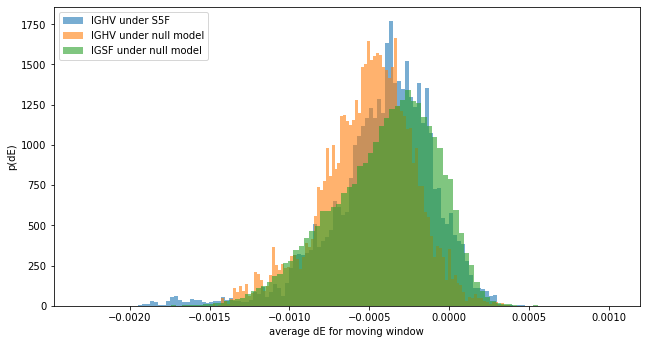

In [596]:
plt.hist(muts_S5F,alpha = 0.6,density= True,bins = 100,label='IGHV under S5F')
plt.hist(muts_null,alpha = 0.6,density= True,bins=100,label = 'IGHV under null model')
plt.hist(muts_igsf,alpha = 0.6,density= True,bins=100,label= 'IGSF under null model')

plt.ylabel('p(dE)')
plt.xlabel('average dE for moving window')
plt.legend(loc = 'upper left')
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.show()

In [597]:
np.mean(muts_S5F)

-0.00041388488505144446

In [598]:
np.mean(muts_igsf)

-0.00040494804958763735

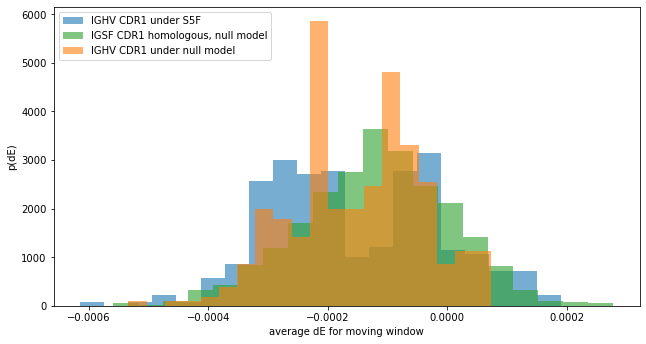

In [599]:
#plt.hist(muts_S5F,alpha = 0.3,density= True,bins = 100,label='IGHV under S5F')
#plt.hist(muts_null,alpha = 0.3,density= True,bins=100,label = 'IGHV under null model')
#plt.hist(muts_igsf,alpha = 0.3,density= True,bins=100,label= 'IGSF under null model')
plt.hist(muts_S5F_cdr1,alpha = 0.6,density= True,bins = 20,color = 'C0',label='IGHV CDR1 under S5F')
plt.hist(muts_igsf_cdr1,alpha = 0.6,density= True,bins=20,color = 'C2',label = 'IGSF CDR1 homologous, null model')
plt.hist(muts_null_cdr1,alpha = 0.6,density= True,bins=20,color = 'C1',label = 'IGHV CDR1 under null model')

plt.ylabel('p(dE)')
plt.xlabel('average dE for moving window')
plt.legend(loc = 'upper left')
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.show()


In [556]:
stats.ttest_ind(a=muts_S5F, b=muts_null, equal_var=True)

Ttest_indResult(statistic=11.716147695079979, pvalue=1.1554933827473691e-31)

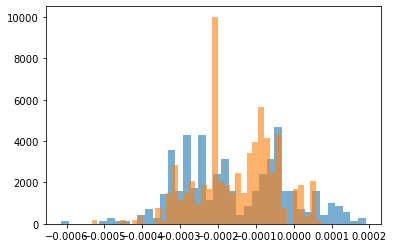

In [557]:
#plt.hist(muts_S5F,alpha = 0.6,density= True,bins = 40)
plt.hist(muts_S5F_cdr1,alpha = 0.6,density= True,bins = 40)
plt.hist(muts_null_cdr1,alpha = 0.6,density= True,bins = 40)

#plt.hist(muts_igsf,alpha = 0.6,density= True,bins = 40)
#plt.hist(muts_igsf_cdr1,alpha = 0.6,density= True,bins = 40)
plt.show()

In [558]:
stats.ttest_ind(a=muts_S5F_cdr1, b=muts_null_cdr1, equal_var=True)

Ttest_indResult(statistic=-0.6895156268734332, pvalue=0.49072865770680385)

In [487]:
np.mean(muts_S5F)

-0.004427214532775606

In [488]:
np.mean(muts_null)

-0.0045435806275110815

In [489]:
n_windows = len(muts_null)

In [490]:
muts_ests_S5F = []
muts_S5F = np.array(muts_S5F)
muts_null = np.array(muts_null)
for i in range(1000):
    resamples = muts_S5F[np.random.randint(0,high = n_windows,size = n_windows)]
    muts_ests_S5F.append(np.mean(resamples))
muts_ests_null = []
for i in range(1000):
    resamples = muts_null[np.random.randint(0,high = n_windows,size = n_windows)]
    muts_ests_null.append(np.mean(resamples))

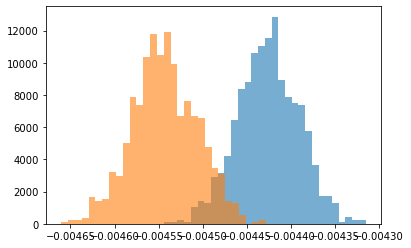

In [492]:
plt.hist(muts_ests_S5F,alpha = 0.6,density= True,bins = 30)
plt.hist(muts_ests_null,alpha = 0.6,density= True,bins=30)
plt.show()